In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install tensorflow_addons

# **LSTM Training**

In [ ]:
#!pip install fasttext

In [ ]:
import numpy as np
import pandas as pd
import platform
import os
#import fasttext
import sys
import tensorflow as tf
import configparser
from tensorflow import keras
from gensim.models.fasttext import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.manifold import TSNE
from tensorflow.keras.utils import pad_sequences, to_categorical
import time
import glob
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
import tensorflow_addons as tfa
from keras import layers
import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras import backend
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)

Colab Active:  True


## Downloads

In [ ]:
if colab_active is True:
  OS = platform.system()      # Operating System

  def data_download(file_to_download, gdrive_code, OS, uncompress = True):
    if not os.path.exists(file_to_download):
      os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
      if OS == "Linux" and uncompress:
          os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
      return True
    else:
      return None

In [ ]:
if colab_active is True:
  out = data_download("./Sentiment_Social_Mood_Datasets.zip", "1kqXuyj2ThXDq5PMyqCr5pOMeRRK9Aq1m", OS)

In [ ]:
if colab_active is True:
  out = data_download("./corpus_2_not_utf.bin", "1AL6CHtciRLTfJsfs6Oldcyg4vlCQmjpb", OS, uncompress = False)

## Configs

In [ ]:
max_tokens = 20000
embedding_size = 300
val_size = 0.1
test_size = 0.1
random_seed = 42
shuffle = True

iterations = 30
batch_size = 32
epochs = 20
tpu = False

## Set the TPU Environment

In [ ]:
if tpu is True:
  import tensorflow as tf
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

  AUTO = tf.data.experimental.AUTOTUNE
  batch_size = batch_size * tpu_strategy.num_replicas_in_sync

## Data

In [ ]:
training_df = pd.read_csv(f"./Sentiment_Social_Mood_Datasets/training_set.csv", sep = ';', encoding='utf-8')
training_df = training_df.loc[training_df['pol'] != 0]
training_df['pol'].replace(2, 0, inplace=True)

In [ ]:
texts = training_df['text']
labels = training_df['pol']

In [ ]:
tokenizer = Tokenizer(num_words = max_tokens)
tokenizer.fit_on_texts(texts)
indexed_texts = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.' )

Found 20826 unique tokens.


In [ ]:
data_x = pad_sequences(indexed_texts, padding='pre')

In [ ]:
#labels = to_categorical(np.asarray(labels))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_x, labels, test_size=val_size, random_state=random_seed, shuffle=shuffle)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_seed, shuffle=shuffle)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6876, 46) (6876,)
(850, 46) (850,)
(765, 46) (765,)


### Embedding Matrix

Import the word embedding model

In [ ]:
#embedding_model = Word2Vec.load('./Sentiment_Social_Mood_Datasets/corpus_2_not_utf_w2v.bin')
#embedding_model = FastText.load('./corpus_2_not_utf.bin')
embedding_model = FastText.load_fasttext_format('./corpus_2_not_utf.bin')

#**Embeddings Visual Sanity Check**

In [ ]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False, topn = 20):

  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [root_word] + [tupla[0] for tupla in model.wv.most_similar(root_word, topn=topn)]
  X = model.wv[tot_words]

  if plot_3d:
    pca = TSNE(perplexity=topn, n_components=3, init='pca', random_state = 42)

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])

    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

In [ ]:
embedding_model.wv.most_similar("covid", topn=10)

[('covidcovid', 0.9673317074775696),
 ('covid[]', 0.9355220794677734),
 ('covidè', 0.9296701550483704),
 ('ècovid', 0.9140629768371582),
 ('xcovid', 0.9068671464920044),
 ('àcovid', 0.9053578972816467),
 ('ncovid', 0.9006012082099915),
 ('covidcoronavirus', 0.8957855105400085),
 ('coronaviruscovid', 0.895122230052948),
 ('dcovid', 0.8895282745361328)]

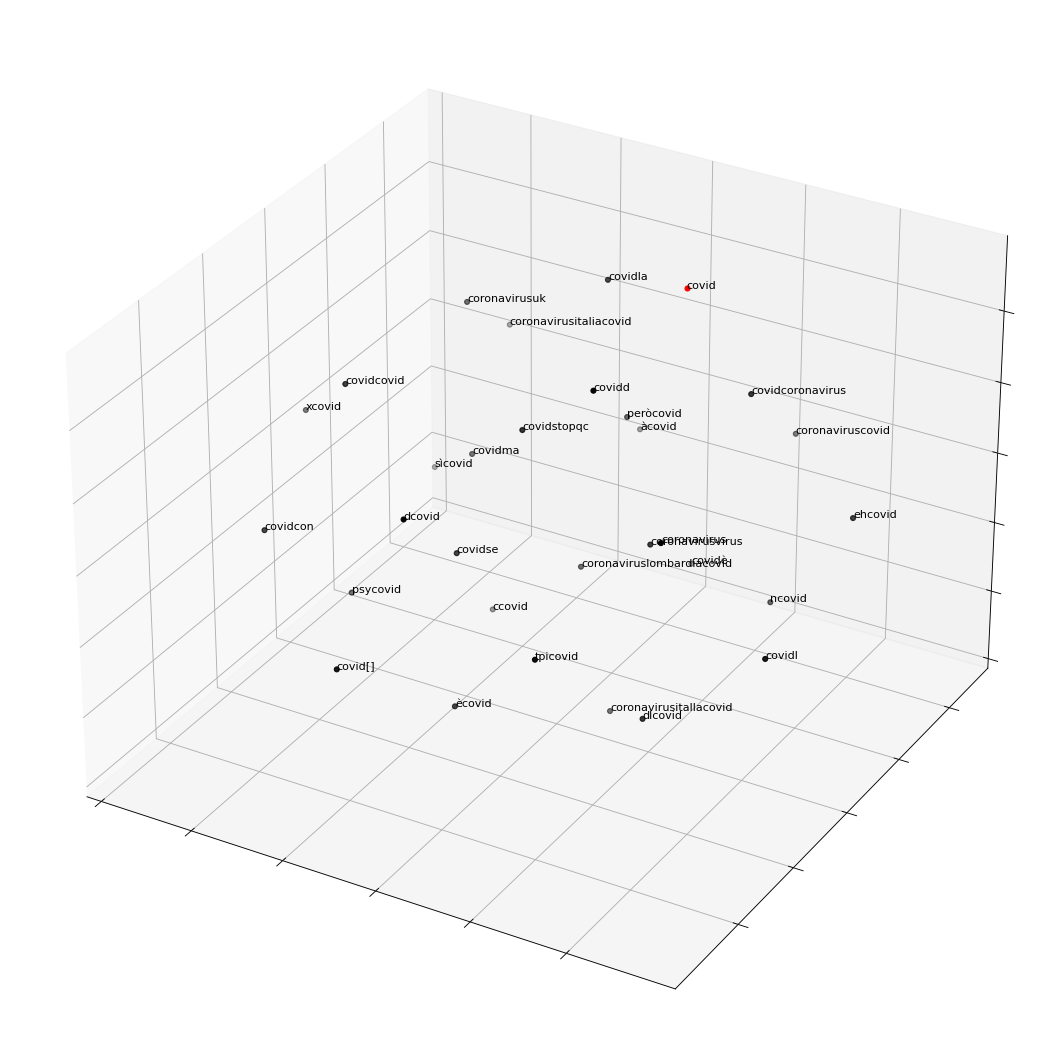

In [ ]:
embedding_space_visualization("covid", embedding_model, topn = 30)

Build the embedding matrix

In [ ]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_size))

for word, idx in word_index.items():
    try:
        embedding_matrix[idx] = embedding_model[word]
    except:
        pass

## LSTM Model

### Layers

In [ ]:
class BiLSTM():

    @staticmethod
    def build(embedding_matrix):
      # Embedding layer
      embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                weights=[embedding_matrix],
                                input_length=x_train.shape[1],
                                trainable = True)
      inputs = layers.Input(shape=(None,), dtype='int64')
      embedded_sequences = embedding_layer(inputs)
      # Hidden layers
      x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5))(embedded_sequences)
      x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.5))(x)
      x = GlobalMaxPooling1D()(x)
      # Output layer
      outputs = Dense(1, activation="sigmoid")(x)
      neural_model = Model(inputs, outputs)
      neural_model.summary()

      return neural_model

In [ ]:
if tpu is True:
  with strategy.scope():
    neural_model = BiLSTM.build(embedding_matrix)
else:
  neural_model = BiLSTM.build(embedding_matrix)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         6248100   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 64)         73984     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                           

#### Compilation & Callbacks

In [ ]:
default_callbacks = []

In [ ]:
checkpoint = ModelCheckpoint('sentiment_bilstm_best.hdf5',
                             save_weights_only=True,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

default_callbacks = default_callbacks + [checkpoint]

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_delta = 0.01,
                              min_lr=0.001)
default_callbacks = default_callbacks+[reduce_lr]

In [ ]:
neural_model.compile(Nadam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#neural_model.compile('rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#### Training

In [ ]:
neural_model.fit(x_train, y_train,
                 validation_data=(x_val, y_val),
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks=default_callbacks,
                 verbose=2)

neural_model.save_weights('sentiment_bilstm_last.hdf5')

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.67740, saving model to sentiment_bilstm_best.hdf5
4/4 - 17s - loss: 0.6882 - accuracy: 0.6134 - val_loss: 0.6774 - val_accuracy: 0.5918 - lr: 0.0010 - 17s/epoch - 4s/step
Epoch 2/20

Epoch 2: val_loss improved from 0.67740 to 0.65990, saving model to sentiment_bilstm_best.hdf5
4/4 - 4s - loss: 0.6655 - accuracy: 0.6134 - val_loss: 0.6599 - val_accuracy: 0.5918 - lr: 0.0010 - 4s/epoch - 1s/step
Epoch 3/20

Epoch 3: val_loss improved from 0.65990 to 0.53090, saving model to sentiment_bilstm_best.hdf5
4/4 - 4s - loss: 0.5713 - accuracy: 0.6662 - val_loss: 0.5309 - val_accuracy: 0.7565 - lr: 0.0010 - 4s/epoch - 1s/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.53090
4/4 - 4s - loss: 0.3271 - accuracy: 0.8812 - val_loss: 0.5440 - val_accuracy: 0.7753 - lr: 0.0010 - 4s/epoch - 1s/step
Epoch 5/20

Epoch 5: val_loss improved from 0.53090 to 0.51402, saving model to sentiment_bilstm_best.hdf5
4/4 - 4s - loss: 0.2667 - accuracy: 0.9

In [ ]:
model_json = neural_model.to_json()
with open("./sentiment_bilstm_topology.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
neural_model.load_weights("sentiment_bilstm_last.hdf5")

In [ ]:
# Prediction of Last Model
pred_test = neural_model.predict(x_test)
pred_test = np.where(pred_test > 0.5, 1, 0)
# Performance of Last Model
accuracy_test = accuracy_score(y_test.values, pred_test)
auc_roc_score = roc_auc_score(y_test.values, pred_test)
f1_score_test = f1_score(y_test.values, pred_test)
print('\nAccuracy of Last Neural Model on Test Set : ', accuracy_test)
print('ROC AUC Score of Last Neural Model on Test Set', auc_roc_score)
print('F1_score of Last Neural Model on Test Set : ', f1_score_test)

24/24 [==============================] - 2s 33ms/step

Accuracy of Last Neural Model on Test Set :  0.7294117647058823
ROC AUC Score of Last Neural Model on Test Set 0.7198477708237323
F1_score of Last Neural Model on Test Set :  0.6449399656946827


<hr>

In [ ]:
neural_model.load_weights("sentiment_bilstm_best.hdf5")

In [ ]:
# Prediction of Last Model
pred_test = neural_model.predict(x_test)
pred_test = np.where(pred_test > 0.5, 1, 0)
# Performance of Last Model
accuracy_test = accuracy_score(y_test.values, pred_test)
auc_roc_score = roc_auc_score(y_test.values, pred_test)
f1_score_test = f1_score(y_test.values, pred_test)
print('\nAccuracy of Best Neural Model on Test Set : ', accuracy_test)
print('ROC AUC Score of Best Neural Model on Test Set', auc_roc_score)
print('F1_score of Best Neural Model on Test Set : ', f1_score_test)

24/24 [==============================] - 1s 21ms/step

Accuracy of Best Neural Model on Test Set :  0.7751633986928105
ROC AUC Score of Best Neural Model on Test Set 0.765167169637415
F1_score of Best Neural Model on Test Set :  0.6993006993006994
